# Introduction to Recurrent Neural Networks (RNNs)
## An intro to sequence classification, and an aside on LSTMs

Before you get started on this assignment, please make sure to look at the note in the Teaching folder in the repository to review the concepts behind RNN architectures. This initial toy example will help you practice building RNNs and LSTMs -- much of the work required in the main project will build off of this initial warm up assignment.

In [1]:
#Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.layers import Bidirectional, SimpleRNN, LSTM, Dense
from keras.models import Sequential
import itertools

## Recurrent Neural Networks (RNNs) - An intro to sequence classification, and an aside on LSTMs

To get you started, we look at a simple example built specifically for RNNs - digit sequence classification. Like in the previous assignment, we're in the aiport again, and we've been asked to help with luggage weights. We define the problem as follows: assume you are an airline company running baggage checks at the airport. The maximum total baggaged weight allowed for the flight is $1570$ pounds. We classify a baggage weight with label $0$ if the cumulative sum so far is lesser than the threshold, and $1$ if it goes above the threshold. Also assume that the length of all sequences is $35$. For example:

Sequence: $500, 500, 500, 327, 294, 102, \ldots$  
Labels  : $0  , 0  , 0  , 1  , 1  , 1, \ldots$

We will also plot confusion matrices and accuracy plots to inform our decisions about the model. Here's a quick refresher/introduction to confusion matrices: A confusion matrix is a way to visualize classifier performance (both binary and multiclass classifiers) - specifically, the matrix captures the number of True Positives (predicted 1 and true label 1), True Negatives (predicted 0 and true label 0), False Positives (predicted 1 but true label 0) and False Negatives (predicted 0 but true label 1). 

You can also refer to this link for more information: https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/#:~:text=A%20confusion%20matrix%20is%20a,related%20terminology%20can%20be%20confusing.


### Data Generation

Generate sequence data using the functions defined below:

In [2]:
baggage_threshold = 1000
sequence_len = 35

def generate_sequence(sequence_len):
    data = np.random.choice(521, sequence_len) #generate random ints in the given range
    labels = np.array([0 if np.sum(data[: i+1]) <= 1570 else 1 for i in range(len(data))])
    
    return data, labels


In [3]:
#construct data matrix X and labels y
X = np.zeros((1000, 35))
y = np.zeros((1000, 35))

#TODO: your code here
for row in range(X.shape[0]): 
    x_gen, y_gen = generate_sequence(sequence_len)
    X[row, :] = x_gen
    y[row, :] = y_gen
    
#split into training and testing data using an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Models

For this section, we will be using the keras API (which is part of tensorflow) extensively to construct our neural nets. You should have seen this before (in Week 8), but here's a few links that may be helpful for this section: <br>
 - https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN <br>
 - https://keras.io/api/layers/recurrent_layers/lstm/ <br>
 - https://keras.io/api/layers/recurrent_layers/bidirectional/ <br>

Now, we train a simple RNN to classify our data! We will be using binary cross-entropy loss, which you will see later in this notebook as well.  Here is some starter code to help you out:

In [4]:
model_1 = Sequential()
model_1.add(SimpleRNN(20, input_shape = (35, 1), return_sequences = True))

#add an output layer (Hint: Look up sigmoid activation)
#TODO: your code here
model_1.add(Dense(1, activation='sigmoid'))

#compile your model with a binary cross-entropy loss and fit it using X_train and y_train
#TODO: your code here
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

for row in range(len(X_train)): 
    curr_x = X_train[row]
    curr_y = y_train[row]
    
    X = curr_x.reshape(1, sequence_len, 1)
    y = curr_y.reshape(1, sequence_len, 1)
    
    model_1.fit(X, y, verbose = False)

Now, let's check our model accuracy on the test set: 

In [5]:
#evaluate your model on the test set and report the test loss and accuracy
#TODO: your code here
model_1.evaluate(X_test.reshape(200, 35, 1), y_test.reshape(200, 35, 1))

7/7 [==============================] - 0s 4ms/step - loss: 0.3499 - accuracy: 0.8773


[0.34986183047294617, 0.8772857189178467]

We can better illustrate our prediction performance using a confusion matrix. Recall that a confusion matrix is a matrix in which each row represents an actual label and each column represents a predicted label such that the value in the row for label $i$ and column for label $j$ represents the number of datapoints with actual label $i$ for which the model predicted label $j$. So in our binary classification case, there are 2 possible labels -- $0$ and $1$, so the off-diagonal elements of the confusion matrix tell us how many $x$s with actual label $0$ were predicted $1$ and how many $x$s with actual label $1$ were predicted $0$ while the diagonal elements tell us how many $x$s were correctly predicted, for actual label $0$ and $1$.

We plot the confusion matrix for this model below.

In [6]:
#flatten predictions tensor into a list
pred = list(itertools.chain(*model_1.predict_classes(X_test.reshape(200, 35, 1))))
pred = [i[0] for i in pred]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [7]:
#flatten y_test values into a list
actual = []
for row in range(len(y_test)): 
    actual += list(y_test[row])

In [8]:
#horizontal axis is predicted label, vertical axis is actual label
conf_mat = confusion_matrix(actual, pred, labels = [0, 1])
df_cm = pd.DataFrame(conf_mat)
df_cm

,0,1
0,285,842
1,17,5856


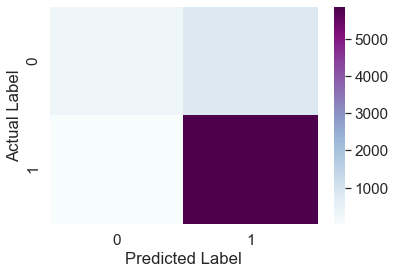

In [9]:
#code to plot the confusion matrix
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, cmap="BuPu")
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()


#### Discussion Question 1: What do you see in the confusion matrix? What labels does the simple RNN classify well, and where does it struggle?

**Answer here:** Not bad! Although we have a high overall accuracy, the confusion matrix shows that there are many terms with an actual label of $0$ that are classifier predicts to be $1$.

Let's see if we can do better using LSTMs (a form of RNNs, refer to the note for more details) - make a new model that uses an LSTM layer instead of a simple RNN. Notice that it makes sense to use LSTMs here because we would like our model to remember earlier baggage weights to classify future baggage weights in the sequence.

In [10]:
model_2 = Sequential()

#add an LSTM layer and a dense layer -- use 20 units for the LSTM (same as for the SimpleRNN)
#TODO: your code here
model_2.add(LSTM(20, input_shape = (35, 1), return_sequences = True))
model_2.add(Dense(1, activation='sigmoid'))

#compile your model with a binary cross-entropy loss and fit it using X_train and y_train
#TODO: your code here
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

for row in range(len(X_train)): 
    curr_x = X_train[row]
    curr_y = y_train[row]
    
    X = curr_x.reshape(1, sequence_len, 1)
    y = curr_y.reshape(1, sequence_len, 1)
    
    model_2.fit(X, y, verbose = False)

Now, let's check our model accuracy on the test set: 

In [11]:
#evaluate your model on the test set and report the test loss and accuracy
#TODO: your code here
model_2.evaluate(X_test.reshape(200, 35, 1), y_test.reshape(200, 35, 1))

7/7 [==============================] - 0s 6ms/step - loss: 0.1889 - accuracy: 0.9353


[0.18886922299861908, 0.9352856874465942]

We again plot the confusion matrix for this model below.

In [12]:
#flatten predictions tensor into a list
pred = list(itertools.chain(*model_2.predict_classes(X_test.reshape(200, 35, 1))))
pred = [i[0] for i in pred]


In [13]:
#generate confusion matrix
conf_mat = confusion_matrix(actual, pred, labels = [0, 1])
df_cm = pd.DataFrame(conf_mat, range(2), range(2))
df_cm

,0,1
0,861,266
1,187,5686


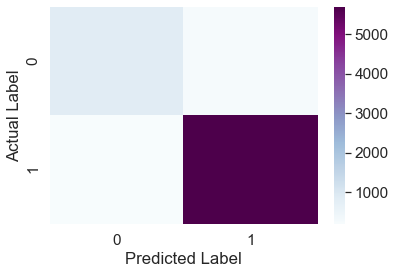

In [14]:
#code to plot the confusion matrix
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, cmap="BuPu")
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()


#### Discussion Question 2: Did the LSTM improve classification accuracy? Why? Answer using what you see from the confusion matrix.

**Answer here:** Even better! As you can see from the confusion matrix, there are fewer false positives, i.e. terms that are predicted to be under label $1$ but are actually under label $0$.

Now let's try using a Bidirectional LSTM as our model:

In [15]:
model_3 = Sequential()

#add a Bidirectional LSTM layer and a dense layer -- use 20 units for the Bi-LSTM (same as for the SimpleRNN)
#TODO: your code here
model_3.add(Bidirectional(LSTM(20, input_shape = (35, 1), return_sequences = True)))
model_3.add(Dense(1, activation='sigmoid'))

#compile your model with a binary cross-entropy loss and fit it using X_train and y_train
#TODO: your code here
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

for row in range(len(X_train)): 
    curr_x = X_train[row]
    curr_y = y_train[row]
    
    X = curr_x.reshape(1, sequence_len, 1)
    y = curr_y.reshape(1, sequence_len, 1)
    
    model_3.fit(X, y, verbose = False)

Now, let's check our model accuracy on the test set: 

In [16]:
#evaluate your model on the test set and report the test loss and accuracy
#TODO: your code here
model_3.evaluate(X_test.reshape(200, 35, 1), y_test.reshape(200, 35, 1))

7/7 [==============================] - 0s 6ms/step - loss: 0.2942 - accuracy: 0.8754


[0.29419028759002686, 0.8754285573959351]

We again plot the confusion matrix for this mode below.

In [17]:
#flatten predictions tensor into a list
pred = list(itertools.chain(*model_3.predict_classes(X_test.reshape(200, 35, 1))))
pred = [i[0] for i in pred]

#generate confusion matrix
conf_mat = confusion_matrix(actual, pred, labels = [0, 1])
df_cm = pd.DataFrame(conf_mat, range(2), range(2))
df_cm


,0,1
0,259,868
1,4,5869


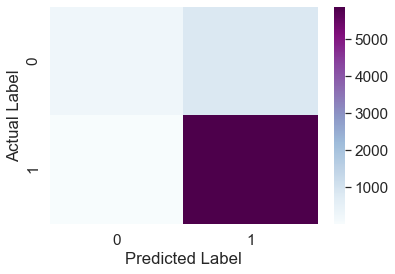

In [18]:
#code to plot the confusion matrix
sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, cmap="BuPu")
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.show()

#### Discussion Question 3: Discuss what you see in the case of Bi-Directional LSTMs

**Answer here:** Any reasonable answer based on the confusion matrix

### Accuracy and Loss Plots

Now, generate a plot of training set accuracy and loss as a function of the number of epochs that our model has trained for. This shows us how much better our training set accuracy improves with each additional epoch of training. To better understand whether or not we are overfitting after a certain number of epochs, we would have to include a validation set. We have not done that here but feel free to play around with generating a validation set from our data and also including plots for validation accuracy and loss to determine the optimal number of epochs.

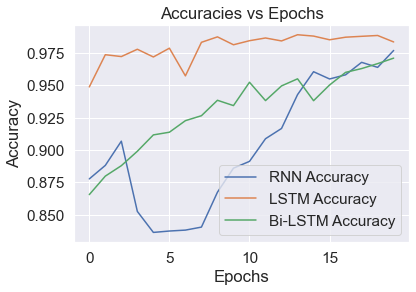

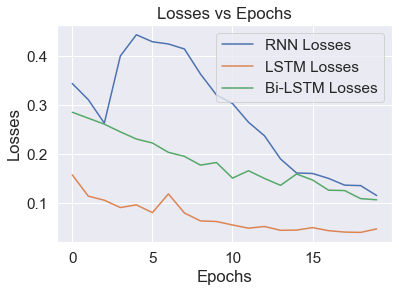

In [19]:
num_epochs = 20

model_1_history = model_1.fit(X_train.reshape(800, 35, 1), y_train.reshape(800, 35, 1), 
                                   epochs=num_epochs, verbose=False)

model_2_history = model_2.fit(X_train.reshape(800, 35, 1), y_train.reshape(800, 35, 1), 
                                   epochs=num_epochs, verbose=False)

model_3_history = model_3.fit(X_train.reshape(800, 35, 1), y_train.reshape(800, 35, 1), 
                                   epochs=num_epochs, verbose=False)
    
train_losses_1 = model_1_history.history['loss']
train_accuracies_1 = model_1_history.history['accuracy']


train_losses_2 = model_2_history.history['loss']
train_accuracies_2 = model_2_history.history['accuracy']

train_losses_3 = model_3_history.history['loss']
train_accuracies_3 = model_3_history.history['accuracy']

plt.figure()
plt.title("Accuracies vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(train_accuracies_1, label="RNN Accuracy")
plt.plot(train_accuracies_2, label="LSTM Accuracy")
plt.plot(train_accuracies_3, label="Bi-LSTM Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.title("Losses vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.plot(train_losses_1, label="RNN Losses")
plt.plot(train_losses_2, label="LSTM Losses")
plt.plot(train_losses_3, label="Bi-LSTM Losses")
plt.legend()
plt.show()


Note here that in the Bidirectional case, you may have either gotten a marginal increase in accuracy or a slight decrease in accuracy, depending on how your sequences were generated. While this example was specifically desgined to make RNNs and LSTMs shine, we hope this gives you an appreciation for the kinds of problems we can solve using Recurrent Networks, and how improvements can be made to the simple RNN architecture. Next, in the main project, we will try to use RNNs to tackle a much harder problem - stock price classification!

## References

- How to Develop a Bidirectional LSTM For Sequence Classification in Python with Keras: <br> https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/